# Transfer Learning for BigEarthNet Model with Multispectral Images

This notebook holds the code to use a BigEarthNet classifier originally trained by U Berlin and BIFOLD for transfer learning with a custom classifier. This code is in pytorch lighting, since the original model was trained in pytorch.

[BIFOLD huggingface repo](https://huggingface.co/BIFOLD-BigEarthNetv2-0/convmixer_768_32-s2-v0.2.0)

Resources: pytorch lighting documentation and chatgpt.





In [1]:
# ensure the note is running in the right env and interpreter 

import sys, os
# Full path to the Python executable in use:
print("sys.executable ->", sys.executable)

# The environment prefix (usually the env directory):
print("sys.prefix     ->", sys.prefix)

# If Conda set the env vars, this gives the env name:
print("CONDA_DEFAULT_ENV ->", os.environ.get("CONDA_DEFAULT_ENV"))

sys.executable -> /home/jupyter-dai7591/.conda/envs/dl4m_final/bin/python
sys.prefix     -> /home/jupyter-dai7591/.conda/envs/dl4m_final
CONDA_DEFAULT_ENV -> None


In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchgeo.datasets import EuroSAT
from torchmetrics.classification import Accuracy
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from reben_training_scripts.reben_publication.BigEarthNetv2_0_ImageClassifier import BigEarthNetv2_0_ImageClassifier
import matplotlib.pyplot as plt
import numpy as np
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import tqdm as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from preprocess_sat import EuroSATS2
from configilm.extra.BENv2_utils import stack_and_interpolate, band_combi_to_mean_std

# For huggingface models 
#from huggingface_hub import snapshot_download
#model_dir = snapshot_download("BIFOLD-BigEarthNetv2-0/convmixer_768_32-s2-v0.1.1")

/home/jupyter-dai7591/.conda/envs/dl4m_final/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Visualize the dataset
Do this AFTER downloading the dataset (and before transforming it). 
Check there is a difference in labels and visualize.

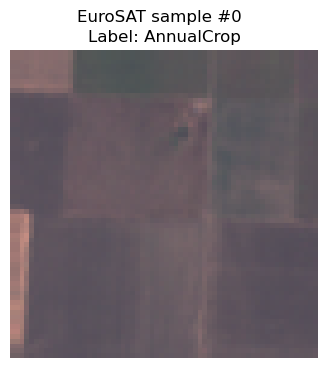

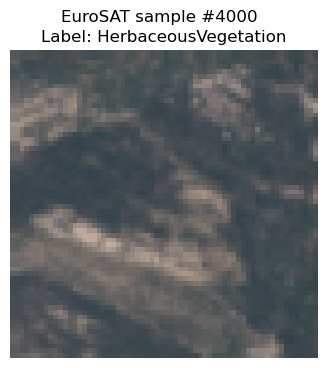

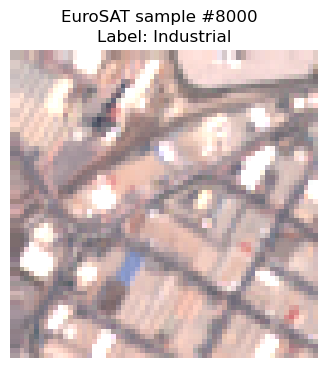

In [3]:
# Check there is a difference in labels and visualize

visualize_dataset = EuroSAT(
    root='data',
    split='train',
)

for i in range(0, 12000, 4000):
    sample = visualize_dataset[i]
    fig = visualize_dataset.plot(
    sample,
    show_titles=True,       
    suptitle=f"EuroSAT sample #{i}")
    plt.show() 

Uncomment for running on mac (m series)

In [4]:
#device = "mps" if torch.backends.mps.is_available() else "cpu"
#print(f"Using device: {device}")

Uncomment for running on cuda gpu

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## Load the datasets into torch dataloaders
These will process and supply the model with batches as it trains to conserve memory use. First create a custom dataset class. 

Model reads following bands: ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]
Dataset includes these bands: ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B10', 'B11', 'B12', 'B8A']

So, we specify which bands to download with the dataset like this:

EuroSAT(root='data', split='train', bands=("B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"), transforms=transform, download=True)

In [6]:
# Bands to import and process for the model
bands = ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]
img_size = 120

# Get mean and std for normalization
mean, std = band_combi_to_mean_std(bands, interpolation="120_nearest")

def euro_sat_transform(sample):
    # sample["image"] is a PIL Image or numpy array with all bands
    img = np.array(sample["image"])
    # Stack and interpolate bands
    bands_dict = {band: img[i] for i, band in enumerate(bands)}
    img_tensor = stack_and_interpolate(bands_dict, order=bands, img_size=img_size)
    # Normalize
    img_tensor = (img_tensor - torch.tensor(mean)[:, None, None]) / torch.tensor(std)[:, None, None]
    img_tensor = img_tensor.float()  # Ensure float32
    return {"image": img_tensor, "label": sample["label"]}

# Use this transform in your EuroSAT dataset
train_dataset = EuroSAT(
    root='data',
    split='train',
    bands=tuple(bands),
    transforms=euro_sat_transform,
    download=False
)
val_dataset = EuroSAT(
    root='data',
    split='val',
    bands=tuple(bands),
    transforms=euro_sat_transform,
    download=False
)
test_dataset = EuroSAT(
    root='data',
    split='test',
    bands=tuple(bands),
    transforms=euro_sat_transform,
    download=False
)

# Create DataLoaders
batch_size = 218
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=7)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=7)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=7)


# Inspect the datasets
print('size of training dataset:', len(train_dataset))
print('size of val dataset:', len(val_dataset))
print('size of test dataset:', len(test_dataset))

print(train_dataset.classes)            # your 10 land-cover classes
print(next(iter(train_dataset))["label"])  # The classes in the dataset
print(train_dataset[3000]["label"].item()) # Show the value of the label 

size of training dataset: 16200
size of val dataset: 5400
size of test dataset: 5400
['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
tensor(0)
1


## Inspect training data

Take sample from the dataset and visualize it's RGB bands.

In [7]:
# Check how each sample is structured 
sample = train_dataset[3200] 
print("shape of each sample:", sample.keys()) # shape of each sample: dict_keys(['image', 'label'])

# Print the values of a random sample 
img    = sample["image"]
label  = sample["label"].item()
print('This is the first dimension of the image tensor after transform', img[0])
print('This is the label', label)

shape of each sample: dict_keys(['image', 'label'])
This is the first dimension of the image tensor after transform tensor([[0.5677, 0.5677, 0.5677,  ..., 0.5447, 0.5447, 0.5727],
        [0.5677, 0.5677, 0.5677,  ..., 0.5447, 0.5447, 0.5727],
        [0.5677, 0.5677, 0.5677,  ..., 0.5447, 0.5447, 0.5727],
        ...,
        [0.5694, 0.5694, 0.5694,  ..., 0.5644, 0.5644, 0.5694],
        [0.5694, 0.5694, 0.5694,  ..., 0.5644, 0.5644, 0.5694],
        [0.5447, 0.5447, 0.5447,  ..., 0.5611, 0.5611, 0.5513]])
This is the label 1


## Build the model

In [8]:
class BigEarthNetClassifier(pl.LightningModule):
    def __init__(self, num_target_classes=5, dropout_rate=0.15):
        super().__init__()
        # Load pretrained model
        self.backbone = BigEarthNetv2_0_ImageClassifier.from_pretrained(
            "BIFOLD-BigEarthNetv2-0/convmixer_768_32-s2-v0.2.0")
        # Freeze backbone classifier remains trainable
        for param in self.backbone.parameters():
            param.requires_grad = False
        
        # Find the name of the classifier by instantiating the class
        #print("backbone.model children:") 
        #for name, module in self.backbone.model.named_children():
            #print(name, "→", module)
        
        # Remove classifier level 
        self.backbone.model.vision_encoder.head_drop = nn.Identity()
        num_features = self.backbone.model.vision_encoder.head.in_features
        self.backbone.model.vision_encoder.head = nn.Identity()
        
        # Create new classifier 
        self.dropout = nn.Dropout(dropout_rate)
        self.new_classifier = nn.Linear(num_features, num_target_classes) # Input: num_features Output: num_target_classes
        
        # Define loss function
        self.loss_fn = nn.CrossEntropyLoss()

        # Define accuracy metric  
        self.train_acc = Accuracy(task="multiclass", num_classes=num_target_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=num_target_classes)
        self.test_acc = Accuracy(task="multiclass", num_classes=num_target_classes)

    def forward(self, x):
        features = self.backbone(x)
        x = self.dropout(features)
        x = self.new_classifier(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x = batch["image"]   # tensor of shape (C, H, W)
        y = batch["label"]   # tensor of shape (batch,)
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = self.train_acc(logits, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_acc',  acc,  on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x = batch["image"]   # tensor of shape (C, H, W)
        y = batch["label"]   # tensor of shape (batch,)
        logits = self(x)
        loss = self.loss_fn(logits, y)
        val_acc = self.val_acc(logits, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)     
        self.log('val_acc',  val_acc, on_epoch=True, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x = batch["image"]   # tensor of shape (C, H, W)
        y = batch["label"]   # tensor of shape (batch,)
        logits = self(x)
        loss = self.loss_fn(logits, y)
        test_acc = self.test_acc(logits, y)
        self.log('test_loss', loss)
        self.log('test_acc', test_acc)
        return {"test_loss": loss, "test_acc": test_acc}
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=0.001)

        
        # 2) create a ReduceLROnPlateau scheduler
        scheduler = ReduceLROnPlateau(
            optimizer,
            mode='min',        # reduce when val_loss stops decreasing
            factor=0.5,        # LR = LR * factor on plateau
            patience=3,        # epochs with no improvement before reducing
            cooldown=2,        # epochs to wait after LR reduction
            min_lr=1e-6,       # lower bound on learning rate
            verbose=True,
        )

        # 3) return in the tuple form that Lightning expects
        return [optimizer], [{
            "scheduler": scheduler,
            "monitor": "val_loss",}]

## Run training loop for classifier
Once the model is assembled we use the following code to train the classifier level.

In [ ]:
model = BigEarthNetClassifier(num_target_classes=len(train_dataset.classes))

# Create logger
csv_logger = CSVLogger(
    save_dir="logs/",     # directory to hold all runs
    name="bifold_run")     # subfolder for this experiment

# Save the checkpoint with the lowest val_loss
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    save_top_k=1,
    mode='min',
    filename='best-{epoch:02d}-{val_loss:.2f}')

# Disable annoying val dataloader prog bar
class NoValBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        # return a disabled tqdm so it never prints
        return tqdm.tqdm(disable=True)

trainer = pl.Trainer(accelerator=device,
                    max_epochs=80,
                    callbacks=[checkpoint_callback, NoValBar()],
                    logger=csv_logger,)

trainer.fit(model, 
            train_dataloaders=train_dataloader, 
            val_dataloaders=val_dataloader) # Train the model 

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX 6000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/jupyter-dai7591/.conda/envs/dl4m_final/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to acces

Epoch 55:  51%|█████     | 38/75 [00:10<00:10,  3.55it/s, v_num=17, train_acc_step=0.807, val_loss=0.499, val_acc=0.832, train_loss=0.527, train_acc_epoch=0.822]

## Visualize Training Loop

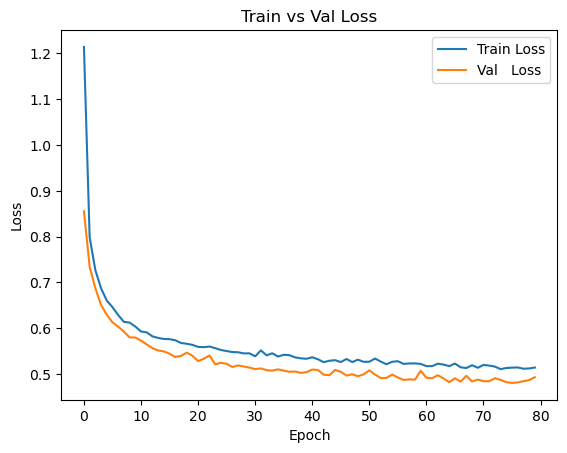

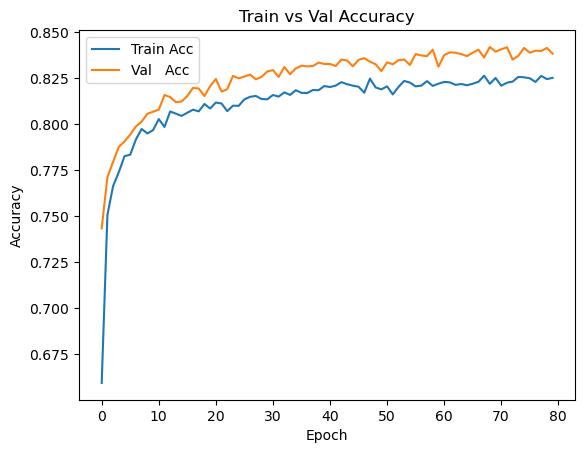

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# 1. Reload your CSV
log_dir     = Path(csv_logger.log_dir)            # e.g. "logs/bifold_run/version_0"
metrics_csv = log_dir / "metrics.csv"
df          = pd.read_csv(metrics_csv)

# 2. Group by epoch and take the last row of each (this has train_loss, train_acc_epoch, val_loss, val_acc)
epoch_summary = df.groupby("epoch").last()

# 3. Plot Loss
plt.figure()
plt.plot(epoch_summary.index, epoch_summary["train_loss"], label="Train Loss")
plt.plot(epoch_summary.index, epoch_summary["val_loss"],   label="Val   Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Train vs Val Loss")
plt.show()

# 4. Plot Accuracy
plt.figure()
plt.plot(epoch_summary.index, epoch_summary["train_acc_epoch"], label="Train Acc")
plt.plot(epoch_summary.index, epoch_summary["val_acc"],         label="Val   Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Train vs Val Accuracy")
plt.show()

## Test model
Load the model and run it on the test data.

In [14]:
#model = BigEarthNetClassifier.load_from_checkpoint(PATH)
model.freeze() # makes the model read-only for inference.
predictions = trainer.test(model, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 25/? [00:06<00:00,  4.14it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8412963151931763     │
│         test_loss         │    0.4741503596305847     │
└───────────────────────────┴───────────────────────────┘